In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import librosa
import librosa.display

import tensorflow as tf
import keras
from keras import layers
from keras import regularizers

In [2]:
df = pd.read_csv(r'UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## Visualize Data

#### Check Data distribution 

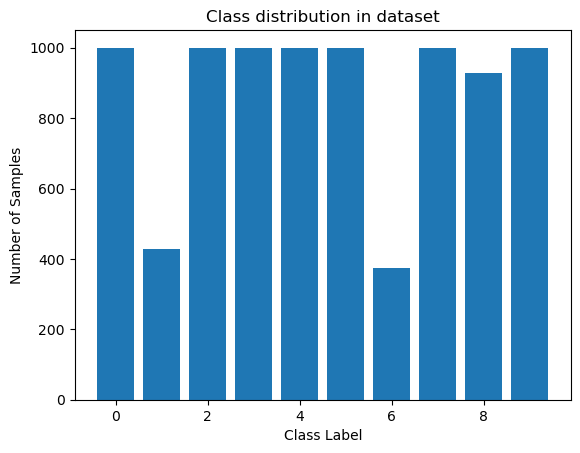

[0 1 2 3 4 5 6 7 8 9] [1000  429 1000 1000 1000 1000  374 1000  929 1000]


In [3]:
unique_labels, counts = np.unique(df['classID'], return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class distribution in dataset')
plt.show()

print(unique_labels, counts)

#### Pick a sample to display  

In [4]:
# 6192, 4729
sample_num = 4729

# get the filename
filename = df.slice_file_name[sample_num] 
print(filename)

path = '../UrbanSound8K/audio/fold' + str(df.fold[sample_num]) + '/' + str(filename)
signal, sr = librosa.load(path, sr=22050) # sr*T -> 22050*4

189895-3-0-0.wav


#### Waveform

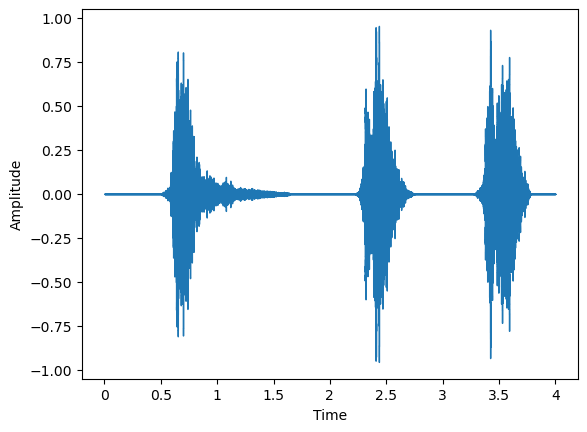

In [5]:
librosa.display.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

#### FFT -> Spectrum

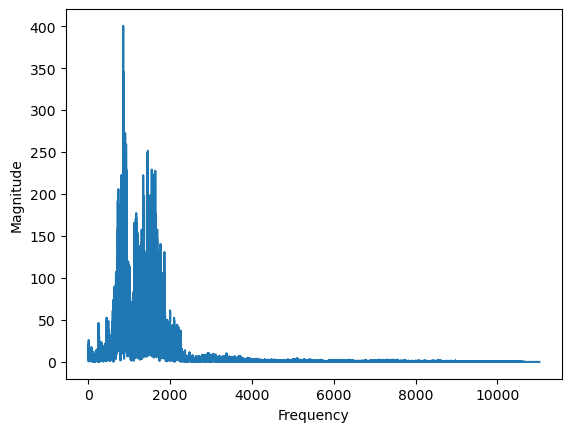

In [6]:
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]

plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

#### STFT -> Spectrogram

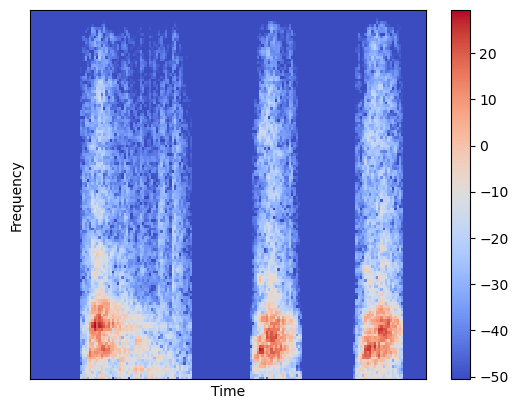

129


In [8]:
n_fft = 256
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectogram = np.abs(stft)
log_spectogram = librosa.amplitude_to_db(spectogram)

librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

print(len(log_spectogram))

#### MFCCs

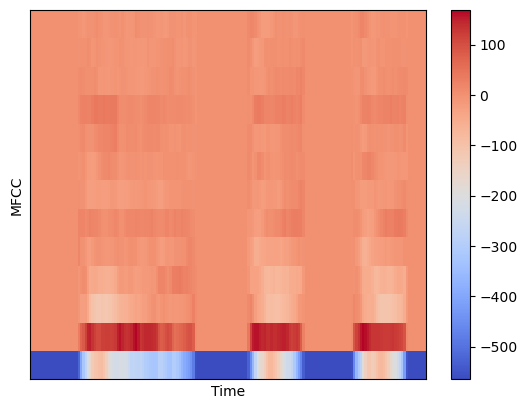

In [8]:
MFCCs = librosa.feature.mfcc(y=signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

## Data Preprocessing and Feature Extraction

#### Padding Audio Files

In [9]:
def zero_padded_data_nparray(audios_path, duration_secs = 4, sr = 22050, files_limit = -1, verbose = False):

    files = librosa.util.find_files(audios_path)
    data_array = []

    for index, path_file in enumerate(files):
        if files_limit != -1 and index >= files_limit: break
        
        if verbose:
            print(f"At audio {index+1}/{len(files)}")
            
        signal, sr = librosa.load(path_file, sr = sr, mono=True)
        
        # zero padding
        if len(signal) < duration_secs*sr:
            signal = np.concatenate([
                signal,
                np.zeros(shape = (duration_secs*sr - len(signal), ))
            ])
        elif len(signal) > duration_secs*sr:
            signal = signal[:duration_secs*sr]
            

        if len(signal) == duration_secs*sr:
            lst = path_file.split("\\")
            file_name = lst[-1]
            newrow = [file_name, signal]
            data_array.append(newrow)
        else:
            print(file_name)
            print(path_file) 
        
    return data_array

#### Feature extraction -> MFCCs

In [18]:
def get_features(df_in, signals, hop_length = 512, n_fft = 2048, n_mfcc = 40, sr = 44100):
    
    MFCCS = [] # list to save MFCCs
    SPECTOGRAM = [] # list to save Spectograms
    labels = [] # list to save labels
    
    for index in range(len(signals)):

        # get the filename        
        filename = signals[index][0]
        if filename:
            
            # find correspondig row in df_in
            row = df_in.loc[df_in["slice_file_name"] == filename]

            if not row.empty:
                # save labels
                label = row.iloc[0,6] 
                
                # Extracting MFCCs
                mfcc = librosa.feature.mfcc(y = np.array(signals[index][1]), 
                                            sr=sr, 
                                            n_fft = n_fft,  
                                            n_mfcc = n_mfcc,
                                            hop_length = hop_length)
                mfcc = mfcc.T
 
                MFCCS.append(np.array([mfcc]))


                # Extracting Spectograms
                stft = librosa.core.stft(y = np.array(signals[index][1]), 
                                         hop_length=hop_length, 
                                         n_fft=246)
                spectogram = np.abs(stft)
                log_spectogram = librosa.amplitude_to_db(spectogram)

                SPECTOGRAM.append(np.array([log_spectogram]))
                
                # Extracting labels
                labels.append(label)
                
            else: 
                print(f"No matching row for filename {filename}")
        else:
            print("Empty filename")

    # check is features and labels  have the same lenght
    assert len(MFCCS) == len(labels) == len(SPECTOGRAM)


    mfcc = np.concatenate(MFCCS, axis = 0)
    spec = np.concatenate(SPECTOGRAM, axis = 0)
    return(np.array(mfcc), np.array(spec), labels)

In [19]:
fold_paths = ["../UrbanSound8K/audio/fold1/", "../UrbanSound8K/audio/fold2/", "../UrbanSound8K/audio/fold3/",
              "../UrbanSound8K/audio/fold4/", "../UrbanSound8K/audio/fold5/", "../UrbanSound8K/audio/fold6/",
              "../UrbanSound8K/audio/fold7/", "../UrbanSound8K/audio/fold8/", "../UrbanSound8K/audio/fold9/",
              "../UrbanSound8K/audio/fold10/"]

mfcc = [10]
spec = [10]
labels = [10]

for i in range(len(fold_paths)): 
    print(fold_paths[i])

    # Adding ZEro-Padding to audio 
    audio = zero_padded_data_nparray(fold_paths[i])

    # Feature Extraction
    mfccs, spectograms, y = get_features(df, audio)

    # Data Normalization Min-Max scaling to [0, 1] 
    mfccs_scaled = (mfccs - np.min(mfccs)) / (np.max(mfccs) - np.min(mfccs))
    spectograms_scaled = (spectograms - np.min(spectograms)) / (np.max(spectograms) - np.min(spectograms))

    # One-Hot Encoding Target feature
    y_encoded = np.zeros((len(y), max(y) +1))
    y_encoded[np.arange(len(y)), y] = 1

    # Saving Features and Labels to 
    mfcc.append(np.array(mfccs_scaled))
    spec.append(np.array(spectograms_scaled))
    labels.append(y_encoded)

features = mfcc[1:]
spec = spec[1:]
labels = labels[1:]


../UrbanSound8K/audio/fold1/
../UrbanSound8K/audio/fold2/
../UrbanSound8K/audio/fold3/
../UrbanSound8K/audio/fold4/
../UrbanSound8K/audio/fold5/
../UrbanSound8K/audio/fold6/
../UrbanSound8K/audio/fold7/
../UrbanSound8K/audio/fold8/
../UrbanSound8K/audio/fold9/
../UrbanSound8K/audio/fold10/


## Building the Recurent Neural Network


#### Build Network topology

In [33]:
input_shape = (124,173)    #(173, 40) # shape of X_train

model = keras.Sequential()

# 2 LSTM layers
model.add(layers.LSTM(128,  input_shape = input_shape, return_sequences = True, activation='tanh', kernel_initializer='random_normal'))
model.add(layers.LSTM(128, return_sequences = True, activation='tanh'))

#model.add(layers.BatchNormalization())

model.add(layers.TimeDistributed(layers.Dense(128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.01))))
model.add(layers.Dropout(0.2))
model.add(layers.TimeDistributed(layers.Dense(64, activation='tanh', kernel_regularizer = regularizers.l2(0.01))))
model.add(layers.Dropout(0.2))
model.add(layers.TimeDistributed(layers.Dense(32, activation='tanh', kernel_regularizer = regularizers.l2(0.01))))
model.add(layers.Dropout(0.2))
model.add(layers.TimeDistributed(layers.Dense(16, activation='tanh', kernel_regularizer = regularizers.l2(0.01))))
model.add(layers.Dropout(0.2))
model.add(layers.TimeDistributed(layers.Dense(8, activation='tanh', kernel_regularizer = regularizers.l2(0.01))))
model.add(layers.Dropout(0.2))


#model.add(layers.BatchNormalization())

# Flatten layer 
model.add(layers.Flatten())

# Output layer
model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 124, 128)          154624    
                                                                 
 lstm_13 (LSTM)              (None, 124, 128)          131584    
                                                                 
 time_distributed_10 (TimeDi  (None, 124, 128)         16512     
 stributed)                                                      
                                                                 
 dropout_14 (Dropout)        (None, 124, 128)          0         
                                                                 
 time_distributed_11 (TimeDi  (None, 124, 64)          8256      
 stributed)                                                      
                                                                 
 dropout_15 (Dropout)        (None, 124, 64)          

#### Compile the Model

The **Adam** optimizer manages the learning rate for stochastic gradient descent. The loss function is **categorical_crossentropy**, which is used when the target label is One-Hot-Encoded. 

In [35]:
optimizer1 = keras.optimizers.Adam(learning_rate = 0.001)
optimizer2 = keras.optimizers.SGD(clipvalue = 0.8, learning_rate = 0.0001)

model.compile(optimizer = optimizer1, loss = 'categorical_crossentropy', metrics=['accuracy'])

## 10-Fold Cross Validation

In [40]:
features = spec

metrics = {'accuracy':[], 'loss':[], 'confusion_matrix':[], 'history':[]}

for fold in range(3,4):
    X_train, y_train = [], []
    X_test, y_test = [], []
        
    # Splitting the data into Test, Validation and Training sets
    for i in range(10):
        if( i != fold):
            X_train += features[i].tolist()
            y_train.extend(labels[i])
            
        else:
            X_test = features[i]
            y_test = labels[i]

        
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
            
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 123)

    # Print sets shapes
    print(f"X_train Shape: {X_train.shape}")
    print(f"X_test Shape: {X_test.shape}")
    #print(f"X_val Shape: {X_val.shape}")

    # Train model
    rnn = model.fit(X_train, y_train, epochs = 50, batch_size = 64, shuffle=False, validation_split = 0.2)

    y_pred = model.predict(X_test)

    y_pred_reshape = np.argmax(y_pred, axis=1)
    y_test_reshape = np.argmax(y_test, axis=1)
    TestLoss, Testacc = model.evaluate(X_test, y_test)

    metrics['accuracy'].append(Testacc)
    metrics['loss'].append(TestLoss)
    metrics['confusion_matrix'].append(confusion_matrix(y_test_reshape, y_pred_reshape))
    metrics['history'].append(rnn.history)


X_train Shape: (6193, 124, 173)
X_test Shape: (990, 124, 173)
Epoch 1/50
78/78 [==============================] - 39s 453ms/step - loss: 1.2802 - accuracy: 0.5894 - val_loss: 1.2689 - val_accuracy: 0.6021
Epoch 2/50
78/78 [==============================] - 28s 364ms/step - loss: 1.2238 - accuracy: 0.6088 - val_loss: 1.1839 - val_accuracy: 0.6223
Epoch 3/50
78/78 [==============================] - 27s 352ms/step - loss: 1.1883 - accuracy: 0.6169 - val_loss: 1.1542 - val_accuracy: 0.6303
Epoch 4/50
78/78 [==============================] - 29s 373ms/step - loss: 1.1636 - accuracy: 0.6284 - val_loss: 1.1565 - val_accuracy: 0.6279
Epoch 5/50
78/78 [==============================] - 29s 379ms/step - loss: 1.1291 - accuracy: 0.6407 - val_loss: 1.2531 - val_accuracy: 0.5981
Epoch 6/50
78/78 [==============================] - 30s 388ms/step - loss: 1.1290 - accuracy: 0.6431 - val_loss: 1.1195 - val_accuracy: 0.6497
Epoch 7/50
78/78 [==============================] - 28s 366ms/step - loss: 1.082

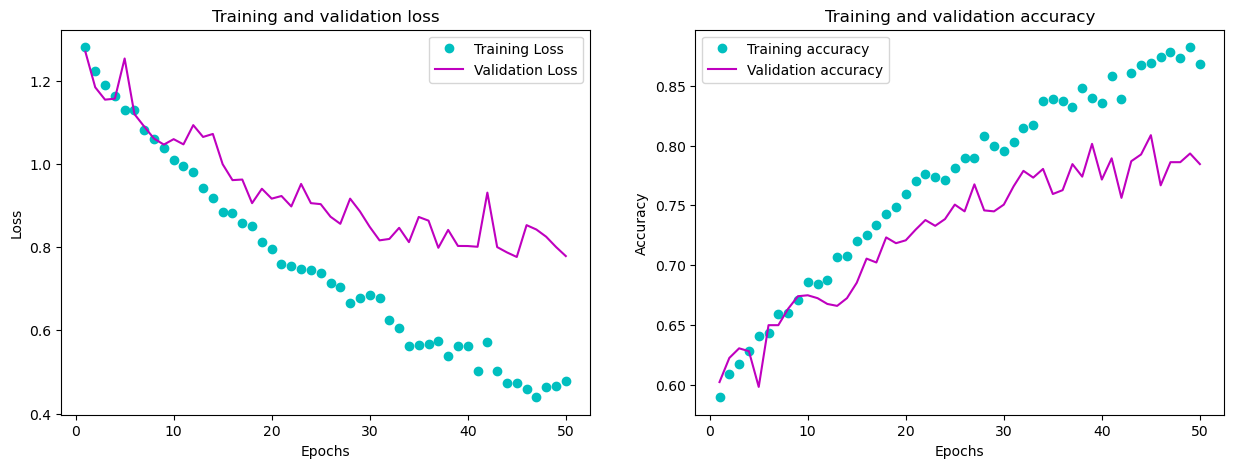

In [41]:
history_dict = rnn.history

loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']

epochs=range(1,51)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [42]:
print(metrics['accuracy'])
print(metrics['loss'])
print(metrics['confusion_matrix'])

[0.5060606002807617]
[2.3273558616638184]
[array([[ 41,   1,   0,   1,   0,  15,   0,  28,   2,  12],
       [  6,  26,   0,   9,   3,   1,   0,  10,   3,   1],
       [  2,   8,  54,  10,   5,   3,   0,   1,   5,  12],
       [  2,   0,   3,  78,   2,   2,   3,   2,   4,   4],
       [  9,   0,   4,   2,  75,   7,   0,   1,   0,   2],
       [ 29,   0,   6,   6,   3,  13,   0,  32,   7,  11],
       [  0,   2,   0,   7,   0,   0,  24,   1,   0,   4],
       [ 17,  12,   2,   0,  28,  28,   2,  30,   0,   1],
       [  6,   0,   6,  27,   4,   3,   0,   0, 114,   6],
       [  6,   0,  23,  12,   6,   3,   0,   0,   4,  46]], dtype=int64)]
